In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn import preprocessing
import xgboost as xgb
import re
from operator import itemgetter
from scipy import sparse
%matplotlib inline

In [665]:
train = pd.read_json('../input/train.json')
test = pd.read_json('../input/test.json')

In [201]:
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [202]:
sample_sub = pd.read_csv('../input/sample_submission.csv')
sample_sub.head()

,listing_id,high,medium,low
0,7142618,0.077788,0.227529,0.694683
1,7210040,0.077788,0.227529,0.694683
2,7174566,0.077788,0.227529,0.694683
3,7191391,0.077788,0.227529,0.694683
4,7171695,0.077788,0.227529,0.694683


In [203]:
for col in train.drop(['features', 'photos'], axis = 1).columns:
    print ('{} has {} unique values'.format(col, len(train[col].value_counts())))

bathrooms has 15 unique values
bedrooms has 9 unique values
building_id has 7585 unique values
created has 48675 unique values
description has 38244 unique values
display_address has 8826 unique values
interest_level has 3 unique values
latitude has 2335 unique values
listing_id has 49352 unique values
longitude has 1677 unique values
manager_id has 3481 unique values
price has 2808 unique values
street_address has 15358 unique values


# Bathrooms

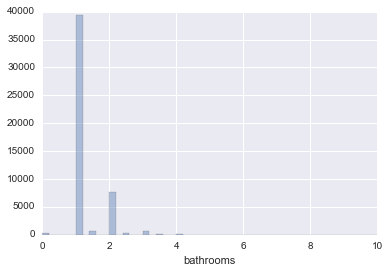

In [204]:
sns.distplot(train.bathrooms, kde = False)
plt.show()

# bedrooms

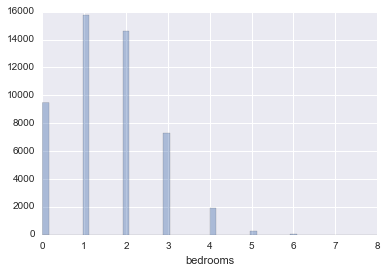

In [205]:
sns.distplot(train.bedrooms, kde = False)
plt.show()

# Price

/Users/JakeHeadings/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


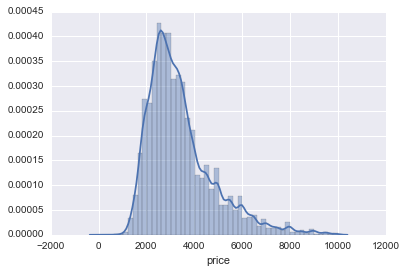

In [206]:
sns.distplot(train[train.price < 10000].price, bins = 50)
plt.show()

# Text Preprocessing


Keywords?
-kitchen, gym, laundry, washer, dryer, dishwasher, ect

In [207]:
train.columns.values

array(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address'], dtype=object)

In [208]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [209]:
import nltk

In [210]:
train[train.interest_level == 'high'].description.iloc[9]

"This is the one. It's a pre-war, two bedroom plus the Park Slope area is lovely. You should absolutely schedule a viewing ASAP.The unit's highlights include east exposure and hardwood floors.You might never need it with New York's many restaurant options, but the eat-in kitchen was gut renovated and comes with an open layout and hardwood flooring. The apartment has a gas oven, a dishwasher, a full-sized fridge, a gas range, and stainless steel appliances.The bedroom has hardwood floors and a window with a view. The bedroom is average sized, and should have room for a queen.This is a great opportunity to rent in a building that's well maintained. The full amenity list includes: a live-in super and a front door buzzer.To schedule a showing and for any more questions, please contact me today. "

In [211]:
train[train.interest_level == 'low'].description.iloc[5]

"This is a spacious four bedroom with every bedroom able to fit queen sized beds with windows and closets and room to spare.  There are ceiling fans and Exposed brick scattered throughout the apartment.  It also has High ceilings, great hardwood floors, an excellent open kitchen with a dishwasher and room for a table, Really great living room that fits a wrap around couch and windows throughout the apartment.<br /><br />Located in the heart of the lower East side you can't help but notice all the neighborhood bars, restaurants, cafes, and boutique shopping.<br /><br />Call, text, or e-mail me today to set up a private viewing.<br /><br /><br /><br />-------------Listing courtesy of Miron Properties. All material herein is intended for information purposes only and has been compiled from sources deemed reliable. Though information is believed to be correct, it is presented subject to errors, omissions, changes or withdrawal without notice.  Miron Properties is a licensed Real Estate Bro

# Feature Engineering

In [212]:
text = ''
for ind, row in train.iterrows():
    for feature in row['features']:
        text = " ".join([text, "_".join(feature.strip().split(" "))])

In [213]:
corpus = pd.Series(text.split(' '))

In [353]:
pd.options.display.max_rows = 1000
corpus.value_counts()

Elevator                                                                                                                                                  25915
Cats_Allowed                                                                                                                                              23540
Hardwood_Floors                                                                                                                                           23527
Dogs_Allowed                                                                                                                                              22035
Doorman                                                                                                                                                   20898
Dishwasher                                                                                                                                                20426
No_Fee                                  

In [666]:
train["num_photos"] = train["photos"].apply(len)
train["num_features"] = train["features"].apply(len)
train["num_description_words"] = train["description"].apply(lambda x: len(x.split(" ")))
train["created"] = pd.to_datetime(train["created"])
train["created_month"] = train["created"].dt.month
train["created_day"] = train["created"].dt.day
train["created_hour"] = train["created"].dt.hour

In [672]:
le = preprocessing.LabelEncoder()
train.interest_level = le.fit_transform(train.interest_level)

features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
             "num_photos", "num_features", "num_description_words",
             "created_month", "created_day", "created_hour", 'low_rate', 'medium_rate', 'high_rate']

# categorical = ["display_address", "manager_id", "building_id", "street_address"]
# for f in categorical:
#         if train[f].dtype=='object':
#             #print(f)
#             lbl = preprocessing.LabelEncoder()
#             lbl.fit(list(train[f].values) + list(test[f].values))
#             train[f] = lbl.transform(list(train[f].values))
#             test[f] = lbl.transform(list(test[f].values))
#             features_to_use.append(f)

#convert categorical feats
for f in categorical:
    cat_counts = pd.DataFrame(train.groupby([f]).size().rename('{}_counts'.format(f)))
    train = train.join(cat_counts, on=f, how='left')
    features_to_use.append('{}_counts'.format(f))

In [667]:
interests = pd.DataFrame(train.groupby(['manager_id', 'interest_level'])['interest_level'].agg(['count'])).reset_index()
id_counts = pd.DataFrame(train.groupby(['manager_id']).size().rename('total_count'))
int_lvl_rates = interests.join(id_counts, how='inner', on='manager_id')
int_lvl_rates['count'] = int_lvl_rates['count'].apply(float)
int_lvl_rates['total_count'] = int_lvl_rates['total_count'].apply(float)
int_lvl_rates['manager_id_rate'] = int_lvl_rates['count'] / int_lvl_rates['total_count']
int_lvl_rates.drop('total_count', axis=1, inplace=True)

In [668]:
grouped = int_lvl_rates.pivot(index='manager_id', columns='interest_level', values='manager_id_rate').reset_index()
grouped.columns = ['manager_id', 'low_rate', 'medium_rate', 'high_rate']
grouped.fillna(-1, inplace=True)
grouped.head()
#train.join(int_lvl_rates, on='building_id', how='left').head()

,manager_id,low_rate,medium_rate,high_rate
0,0000abd7518b94c35a90d64b56fbf3e6,-1.0,0.333333,0.666667
1,001ce808ce1720e24a9510e014c69707,-1.0,1.000000,-1.000000
2,003fc4e9a70053082f131b1054966aaf,-1.0,1.000000,-1.000000
3,00607a02f6efd9c6c7c588826e471ee9,-1.0,-1.000000,1.000000
4,00995ff28d79127ed2dca8320e9e7d09,-1.0,0.666667,0.333333


In [669]:
train = train.merge(grouped, on='manager_id', how='left')

In [637]:
# train['features'] = train["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
# test['features'] = test["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
print(train["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=100)
tr_sparse = tfidf.fit_transform(train["features"])
te_sparse = tfidf.transform(test["features"])

0                                                     
1    Doorman Elevator Fitness_Center Cats_Allowed D...
2    Laundry_In_Building Dishwasher Hardwood_Floors...
3                               Hardwood_Floors No_Fee
4                                              Pre-War
Name: features, dtype: object


In [673]:
# ['manager_id', 'building_id', 'street_address', 'display_address']
# for x in ['high_rate', 'medium_rate', 'low_rate']:
#     features_to_use.remove(x)

In [674]:
X = np.array(train[features_to_use])
#X = sparse.hstack([train[features_to_use], tr_sparse]).tocsr()
y = train.interest_level

In [675]:
print (features_to_use)

['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'num_photos', 'num_features', 'num_description_words', 'created_month', 'created_day', 'created_hour', 'low_rate', 'medium_rate', 'high_rate', 'display_address_counts', 'manager_id_counts', 'building_id_counts', 'street_address_counts']


# Cross Validation

In [676]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()


def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance


def intersect(a, b):
    return list(set(a) & set(b))

def runcv(X, y, random_state=0):
    eta = 0.3
    max_depth = 6
    subsample = 0.7
    colsample_bytree = 0.7
    min_child_weight = 1

    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "multi:softprob",
        "booster" : "gbtree",
        "eval_metric": "mlogloss",
        "eta": eta,
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "min_child_weight": min_child_weight,
        "silent": 1,
        "seed": random_state,
        "num_class": 3
    }
    num_boost_round = 115
    early_stopping_rounds = 10

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]

        dtrain = xgb.DMatrix(X_train, y_train)
        dvalid = xgb.DMatrix(X_valid, y_valid)

        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

        print("Validating...")
        yhat = gbm.predict(xgb.DMatrix(X_valid), ntree_limit=gbm.best_iteration+1)
        score = log_loss(y_valid.tolist(), yhat)
        cv_scores.append(score)
        
        imp = get_importance(gbm, features_to_use)
        print('Importance array: ', imp)
        
    print (np.mean(cv_scores))

In [677]:
runcv(X, y)

XGBoost params. ETA: 0.3, MAX_DEPTH: 6, SUBSAMPLE: 0.7, COLSAMPLE_BY_TREE: 0.7
[0]	train-mlogloss:0.899235	eval-mlogloss:0.902782
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:0.783372	eval-mlogloss:0.790128
[2]	train-mlogloss:0.706516	eval-mlogloss:0.716034
[3]	train-mlogloss:0.657167	eval-mlogloss:0.669544
[4]	train-mlogloss:0.622192	eval-mlogloss:0.636678
[5]	train-mlogloss:0.595334	eval-mlogloss:0.612011
[6]	train-mlogloss:0.573564	eval-mlogloss:0.592831
[7]	train-mlogloss:0.558062	eval-mlogloss:0.579309
[8]	train-mlogloss:0.546436	eval-mlogloss:0.569577
[9]	train-mlogloss:0.536278	eval-mlogloss:0.561353
[10]	train-mlogloss:0.527734	eval-mlogloss:0.554249
[11]	train-mlogloss:0.519968	eval-mlogloss:0.548466
[12]	train-mlogloss:0.514184	eval-mlogloss:0.543706
[13]	train-mlogloss:0.508607	eval-mlogloss:0.53949
[14]	train-mlogloss:0.504201	eval-mlogloss:0.53669
[1